<a href="https://colab.research.google.com/github/mohamedhammad/Distributed/blob/master/GMM_2D_3_Components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-1dc75e7f0014>:69: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = Ellipse(mean, v[0], v[1], 180 + angle, edgecolor='black', facecolor='none', linewidth=2)


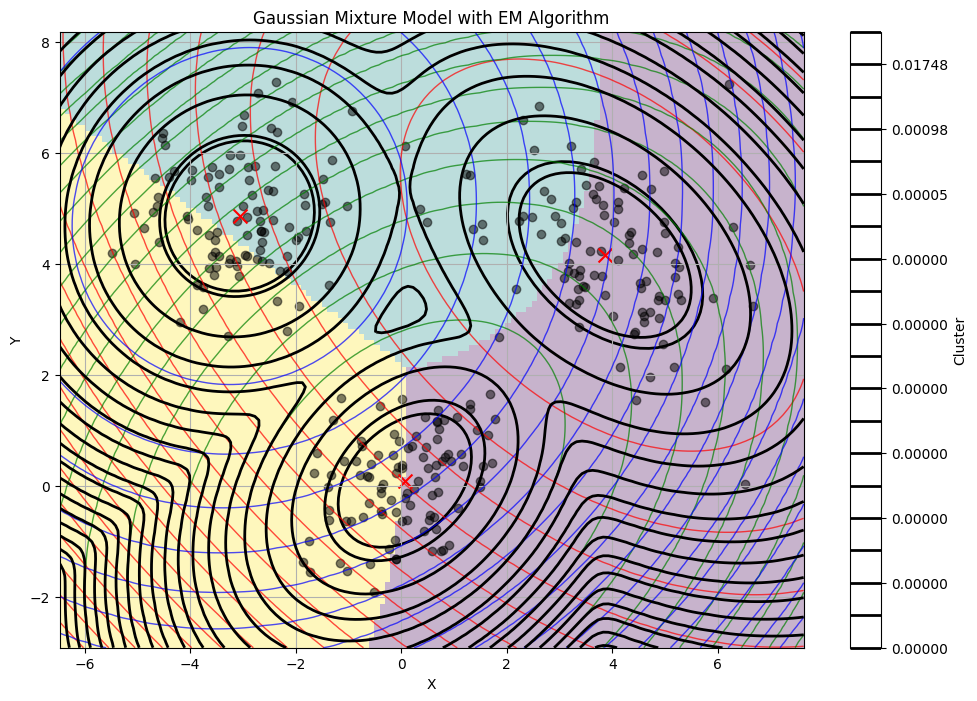

GMM fitting completed.
Number of components: 3
Weights: [0.33760606 0.3307546  0.33163934]
Means: [[ 3.86623522  4.16055705]
 [ 0.06962838  0.09746227]
 [-3.05989868  4.86394152]]
Covariances: [array([[ 1.71048155, -0.65683081],
       [-0.65683081,  1.41636014]]), array([[0.79719727, 0.26532726],
       [0.26532726, 0.72349568]]), array([[1.00209671, 0.05554402],
       [0.05554402, 0.91663154]])]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

# Generate synthetic data
np.random.seed(42)
n_samples = 300

# Generate three clusters
cluster1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], n_samples // 3)
cluster2 = np.random.multivariate_normal([4, 4], [[1.5, -0.5], [-0.5, 1.5]], n_samples // 3)
cluster3 = np.random.multivariate_normal([-3, 5], [[1, 0], [0, 1]], n_samples // 3)

# Combine the clusters
data = np.vstack((cluster1, cluster2, cluster3))

class GaussianMixture:
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances_ = [np.eye(n_features) for _ in range(self.n_components)]

    def e_step(self, X):
        n_samples = X.shape[0]
        resp = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            resp[:, k] = self.weights_[k] * multivariate_normal.pdf(X, self.means_[k], self.covariances_[k])

        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def m_step(self, X, resp):
        n_samples, n_features = X.shape

        self.weights_ = resp.sum(axis=0) / n_samples
        self.means_ = resp.T.dot(X) / resp.sum(axis=0)[:, np.newaxis]

        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = np.dot(resp[:, k] * diff.T, diff) / resp[:, k].sum()

    def fit(self, X):
        self.initialize_parameters(X)

        for _ in range(self.max_iter):
            resp = self.e_step(X)
            self.m_step(X, resp)

    def predict(self, X):
        resp = self.e_step(X)
        return resp.argmax(axis=1)

# Function to plot ellipses
def plot_ellipses(ax, weights, means, covariances):
    for n, (weight, mean, covar) in enumerate(zip(weights, means, covariances)):
        if weight > 0.1:
            v, w = np.linalg.eigh(covar)
            angle = np.arctan2(w[0][1], w[0][0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            ell = Ellipse(mean, v[0], v[1], 180 + angle, edgecolor='black', facecolor='none', linewidth=2)
            ax.add_artist(ell)
            ax.scatter(mean[0], mean[1], c='red', s=100, marker='x')

# Fit the Gaussian Mixture Model
n_components = 3
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Create a mesh grid for plotting
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict labels for each point in the mesh
Z = gmm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the results
plt.figure(figsize=(12, 8))
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.viridis, aspect='auto', alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], c='black', alpha=0.5)
plot_ellipses(plt.gca(), gmm.weights_, gmm.means_, gmm.covariances_)

# Plot contour lines for each Gaussian component
colors = ['red', 'green', 'blue']
for i in range(n_components):
    mu = gmm.means_[i]
    cov = gmm.covariances_[i]

    mvn = multivariate_normal(mu, cov)
    Z = mvn.pdf(np.dstack((xx, yy)))

    levels = np.logspace(np.log10(Z.min()), np.log10(Z.max()), 20)
    plt.contour(xx, yy, Z, levels=levels, colors=colors[i], alpha=0.7, linewidths=1)

# Plot the mixture of Gaussians
Z_mix = np.zeros_like(Z)
for i in range(n_components):
    mvn = multivariate_normal(gmm.means_[i], gmm.covariances_[i])
    Z_mix += gmm.weights_[i] * mvn.pdf(np.dstack((xx, yy)))

levels_mix = np.logspace(np.log10(Z_mix.min()), np.log10(Z_mix.max()), 20)
plt.contour(xx, yy, Z_mix, levels=levels_mix, colors='black', alpha=1, linewidths=2)

plt.title("Gaussian Mixture Model with EM Algorithm")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

print("GMM fitting completed.")
print("Number of components:", n_components)
print("Weights:", gmm.weights_)
print("Means:", gmm.means_)
print("Covariances:", gmm.covariances_)

<ipython-input-4-d8b46738bb00>:69: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = Ellipse(mean, v[0], v[1], 180 + angle, edgecolor='black', facecolor='none', linewidth=2)


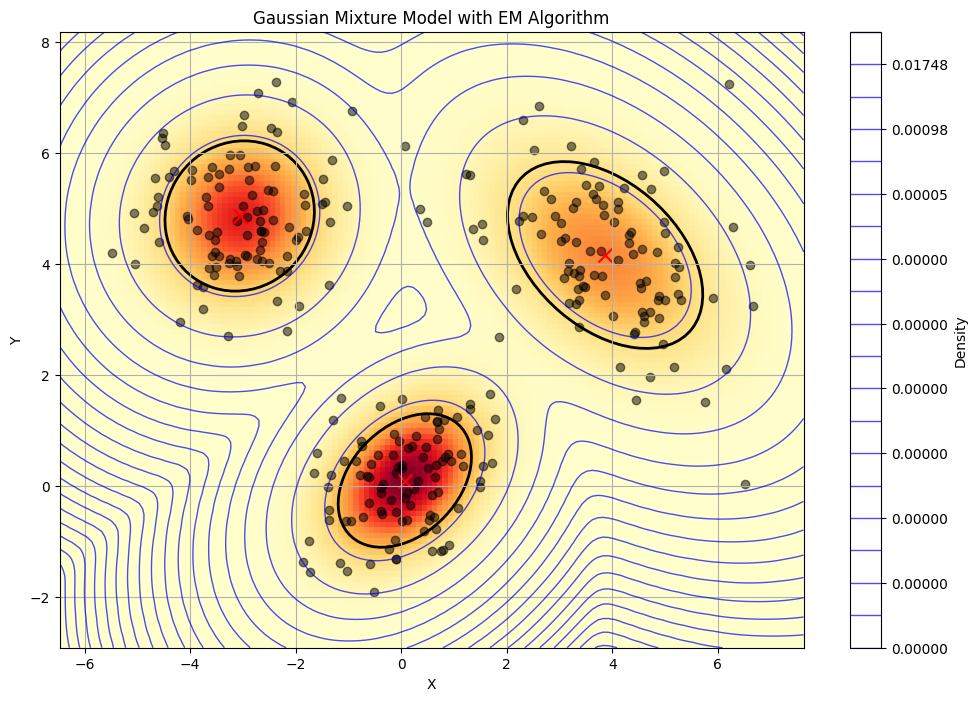

GMM fitting completed.
Number of components: 3
Weights: [0.33760606 0.3307546  0.33163934]
Means: [[ 3.86623522  4.16055705]
 [ 0.06962838  0.09746227]
 [-3.05989868  4.86394152]]
Covariances: [array([[ 1.71048155, -0.65683081],
       [-0.65683081,  1.41636014]]), array([[0.79719727, 0.26532726],
       [0.26532726, 0.72349568]]), array([[1.00209671, 0.05554402],
       [0.05554402, 0.91663154]])]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

# Generate synthetic data
np.random.seed(42)
n_samples = 300

# Generate three clusters
cluster1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], n_samples // 3)
cluster2 = np.random.multivariate_normal([4, 4], [[1.5, -0.5], [-0.5, 1.5]], n_samples // 3)
cluster3 = np.random.multivariate_normal([-3, 5], [[1, 0], [0, 1]], n_samples // 3)

# Combine the clusters
data = np.vstack((cluster1, cluster2, cluster3))

class GaussianMixture:
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances_ = [np.eye(n_features) for _ in range(self.n_components)]

    def e_step(self, X):
        n_samples = X.shape[0]
        resp = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            resp[:, k] = self.weights_[k] * multivariate_normal.pdf(X, self.means_[k], self.covariances_[k])

        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def m_step(self, X, resp):
        n_samples, n_features = X.shape

        self.weights_ = resp.sum(axis=0) / n_samples
        self.means_ = resp.T.dot(X) / resp.sum(axis=0)[:, np.newaxis]

        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = np.dot(resp[:, k] * diff.T, diff) / resp[:, k].sum()

    def fit(self, X):
        self.initialize_parameters(X)

        for _ in range(self.max_iter):
            resp = self.e_step(X)
            self.m_step(X, resp)

    def predict(self, X):
        resp = self.e_step(X)
        return resp.argmax(axis=1)

# Function to plot ellipses
def plot_ellipses(ax, weights, means, covariances):
    for n, (weight, mean, covar) in enumerate(zip(weights, means, covariances)):
        if weight > 0.1:
            v, w = np.linalg.eigh(covar)
            angle = np.arctan2(w[0][1], w[0][0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            ell = Ellipse(mean, v[0], v[1], 180 + angle, edgecolor='black', facecolor='none', linewidth=2)
            ax.add_artist(ell)
            ax.scatter(mean[0], mean[1], c='red', s=100, marker='x')

# Fit the Gaussian Mixture Model
n_components = 3
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Create a mesh grid for plotting
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Calculate the density function of the mixture
Z_mix = np.zeros_like(xx)
for i in range(n_components):
    mvn = multivariate_normal(gmm.means_[i], gmm.covariances_[i])
    Z_mix += gmm.weights_[i] * mvn.pdf(np.dstack((xx, yy)))

# Plot the results
plt.figure(figsize=(12, 8))

# Plot heatmap of the density function
plt.imshow(Z_mix, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap='YlOrRd', aspect='auto', origin='lower')

# Plot data points
plt.scatter(data[:, 0], data[:, 1], c='black', alpha=0.5)

# Plot ellipses
plot_ellipses(plt.gca(), gmm.weights_, gmm.means_, gmm.covariances_)

# Plot contour lines for the mixture of Gaussians
levels_mix = np.logspace(np.log10(Z_mix.min()), np.log10(Z_mix.max()), 20)
plt.contour(xx, yy, Z_mix, levels=levels_mix, colors='blue', alpha=0.7, linewidths=1)

plt.title("Gaussian Mixture Model with EM Algorithm")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label='Density')
plt.grid(True)
plt.show()

print("GMM fitting completed.")
print("Number of components:", n_components)
print("Weights:", gmm.weights_)
print("Means:", gmm.means_)
print("Covariances:", gmm.covariances_)

<ipython-input-5-b47fba341772>:69: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = Ellipse(mean, v[0], v[1], 180 + angle, edgecolor='black', facecolor='none', linewidth=2)


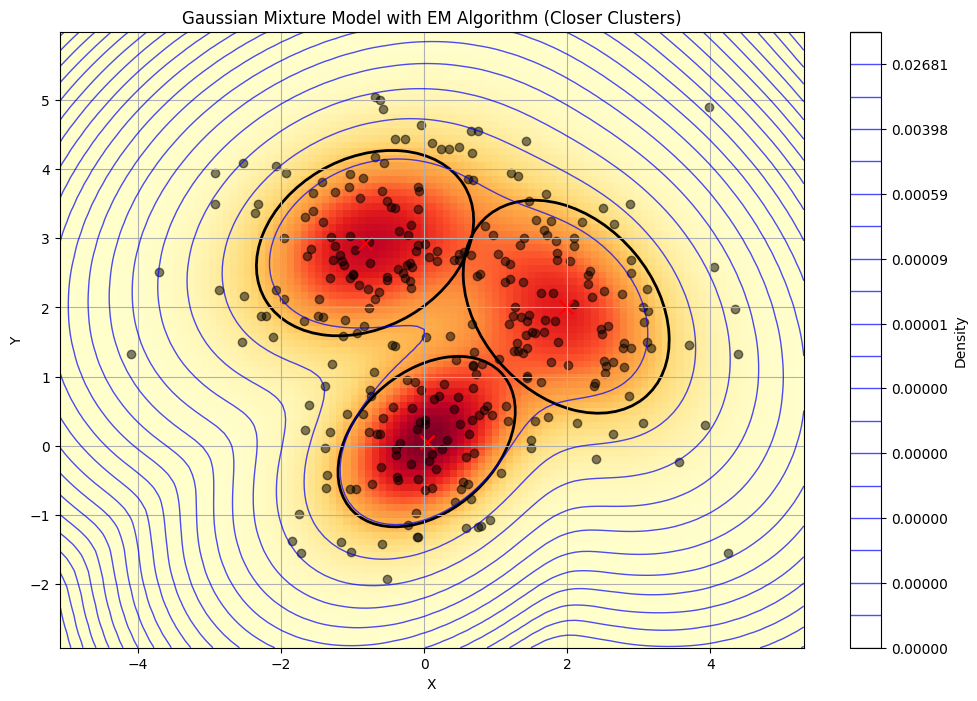

GMM fitting completed.
Number of components: 3
Weights: [0.33056928 0.30966818 0.35976254]
Means: [[ 1.98599628  2.01129408]
 [ 0.03502394  0.06220172]
 [-0.82596384  2.92964363]]
Covariances: [array([[ 1.0362885 , -0.34547586],
       [-0.34547586,  1.18368165]]), array([[0.76747033, 0.27289641],
       [0.27289641, 0.75796698]]), array([[1.15263108, 0.2513217 ],
       [0.2513217 , 0.89614228]])]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

# Generate synthetic data with closer clusters
np.random.seed(42)
n_samples = 300

# Generate three closer clusters
cluster1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], n_samples // 3)
cluster2 = np.random.multivariate_normal([2, 2], [[1.2, -0.4], [-0.4, 1.2]], n_samples // 3)
cluster3 = np.random.multivariate_normal([-1, 3], [[1, 0.2], [0.2, 1]], n_samples // 3)

# Combine the clusters
data = np.vstack((cluster1, cluster2, cluster3))

class GaussianMixture:
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances_ = [np.eye(n_features) for _ in range(self.n_components)]

    def e_step(self, X):
        n_samples = X.shape[0]
        resp = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            resp[:, k] = self.weights_[k] * multivariate_normal.pdf(X, self.means_[k], self.covariances_[k])

        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def m_step(self, X, resp):
        n_samples, n_features = X.shape

        self.weights_ = resp.sum(axis=0) / n_samples
        self.means_ = resp.T.dot(X) / resp.sum(axis=0)[:, np.newaxis]

        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = np.dot(resp[:, k] * diff.T, diff) / resp[:, k].sum()

    def fit(self, X):
        self.initialize_parameters(X)

        for _ in range(self.max_iter):
            resp = self.e_step(X)
            self.m_step(X, resp)

    def predict(self, X):
        resp = self.e_step(X)
        return resp.argmax(axis=1)

# Function to plot ellipses
def plot_ellipses(ax, weights, means, covariances):
    for n, (weight, mean, covar) in enumerate(zip(weights, means, covariances)):
        if weight > 0.1:
            v, w = np.linalg.eigh(covar)
            angle = np.arctan2(w[0][1], w[0][0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            ell = Ellipse(mean, v[0], v[1], 180 + angle, edgecolor='black', facecolor='none', linewidth=2)
            ax.add_artist(ell)
            ax.scatter(mean[0], mean[1], c='red', s=100, marker='x')

# Fit the Gaussian Mixture Model
n_components = 3
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Create a mesh grid for plotting
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Calculate the density function of the mixture
Z_mix = np.zeros_like(xx)
for i in range(n_components):
    mvn = multivariate_normal(gmm.means_[i], gmm.covariances_[i])
    Z_mix += gmm.weights_[i] * mvn.pdf(np.dstack((xx, yy)))

# Plot the results
plt.figure(figsize=(12, 8))

# Plot heatmap of the density function
plt.imshow(Z_mix, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap='YlOrRd', aspect='auto', origin='lower')

# Plot data points
plt.scatter(data[:, 0], data[:, 1], c='black', alpha=0.5)

# Plot ellipses
plot_ellipses(plt.gca(), gmm.weights_, gmm.means_, gmm.covariances_)

# Plot contour lines for the mixture of Gaussians
levels_mix = np.logspace(np.log10(Z_mix.min()), np.log10(Z_mix.max()), 20)
plt.contour(xx, yy, Z_mix, levels=levels_mix, colors='blue', alpha=0.7, linewidths=1)

plt.title("Gaussian Mixture Model with EM Algorithm (Closer Clusters)")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label='Density')
plt.grid(True)
plt.show()

print("GMM fitting completed.")
print("Number of components:", n_components)
print("Weights:", gmm.weights_)
print("Means:", gmm.means_)
print("Covariances:", gmm.covariances_)

<ipython-input-6-0c0682215ce5>:69: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = Ellipse(mean, v[0], v[1], 180 + angle, edgecolor='black', facecolor='none', linewidth=2)


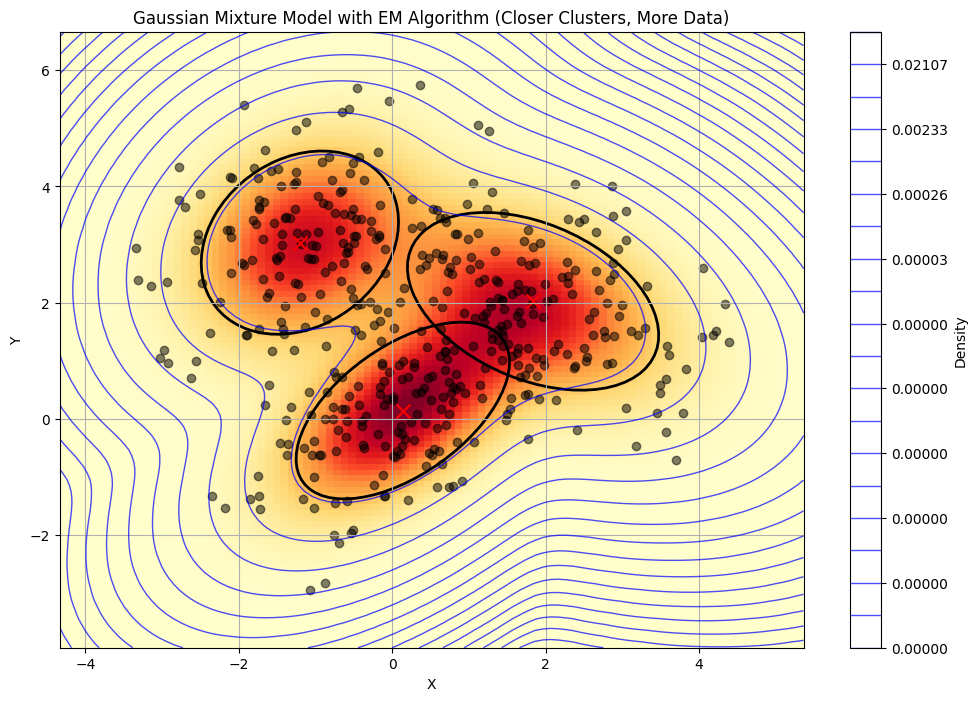

GMM fitting completed.
Number of components: 3
Weights: [0.31627105 0.34659578 0.33713317]
Means: [[-1.2025339   3.03236969]
 [ 0.13979846  0.14308715]
 [ 1.83744141  2.02233218]]
Covariances: [array([[0.82678855, 0.2284286 ],
       [0.2284286 , 1.24280567]]), array([[0.96762377, 0.5813542 ],
       [0.5813542 , 1.15618652]]), array([[ 1.34173341, -0.47785738],
       [-0.47785738,  1.16849571]])]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

# Generate synthetic data with closer clusters and more data points
np.random.seed(42)
n_samples = 450  # Increased from 300 to 450 (50% more)

# Generate three closer clusters with more data points
cluster1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], n_samples // 3)
cluster2 = np.random.multivariate_normal([2, 2], [[1.2, -0.4], [-0.4, 1.2]], n_samples // 3)
cluster3 = np.random.multivariate_normal([-1, 3], [[1, 0.2], [0.2, 1]], n_samples // 3)

# Combine the clusters
data = np.vstack((cluster1, cluster2, cluster3))

class GaussianMixture:
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances_ = [np.eye(n_features) for _ in range(self.n_components)]

    def e_step(self, X):
        n_samples = X.shape[0]
        resp = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            resp[:, k] = self.weights_[k] * multivariate_normal.pdf(X, self.means_[k], self.covariances_[k])

        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def m_step(self, X, resp):
        n_samples, n_features = X.shape

        self.weights_ = resp.sum(axis=0) / n_samples
        self.means_ = resp.T.dot(X) / resp.sum(axis=0)[:, np.newaxis]

        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = np.dot(resp[:, k] * diff.T, diff) / resp[:, k].sum()

    def fit(self, X):
        self.initialize_parameters(X)

        for _ in range(self.max_iter):
            resp = self.e_step(X)
            self.m_step(X, resp)

    def predict(self, X):
        resp = self.e_step(X)
        return resp.argmax(axis=1)

# Function to plot ellipses
def plot_ellipses(ax, weights, means, covariances):
    for n, (weight, mean, covar) in enumerate(zip(weights, means, covariances)):
        if weight > 0.1:
            v, w = np.linalg.eigh(covar)
            angle = np.arctan2(w[0][1], w[0][0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            ell = Ellipse(mean, v[0], v[1], 180 + angle, edgecolor='black', facecolor='none', linewidth=2)
            ax.add_artist(ell)
            ax.scatter(mean[0], mean[1], c='red', s=100, marker='x')

# Fit the Gaussian Mixture Model
n_components = 3
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Create a mesh grid for plotting
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Calculate the density function of the mixture
Z_mix = np.zeros_like(xx)
for i in range(n_components):
    mvn = multivariate_normal(gmm.means_[i], gmm.covariances_[i])
    Z_mix += gmm.weights_[i] * mvn.pdf(np.dstack((xx, yy)))

# Plot the results
plt.figure(figsize=(12, 8))

# Plot heatmap of the density function
plt.imshow(Z_mix, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap='YlOrRd', aspect='auto', origin='lower')

# Plot data points
plt.scatter(data[:, 0], data[:, 1], c='black', alpha=0.5)

# Plot ellipses
plot_ellipses(plt.gca(), gmm.weights_, gmm.means_, gmm.covariances_)

# Plot contour lines for the mixture of Gaussians
levels_mix = np.logspace(np.log10(Z_mix.min()), np.log10(Z_mix.max()), 20)
plt.contour(xx, yy, Z_mix, levels=levels_mix, colors='blue', alpha=0.7, linewidths=1)

plt.title("Gaussian Mixture Model with EM Algorithm (Closer Clusters, More Data)")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label='Density')
plt.grid(True)
plt.show()

print("GMM fitting completed.")
print("Number of components:", n_components)
print("Weights:", gmm.weights_)
print("Means:", gmm.means_)
print("Covariances:", gmm.covariances_)

<ipython-input-7-7d7022954fe2>:69: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = Ellipse(mean, v[0], v[1], 180 + angle, edgecolor='black', facecolor='none', linewidth=2)


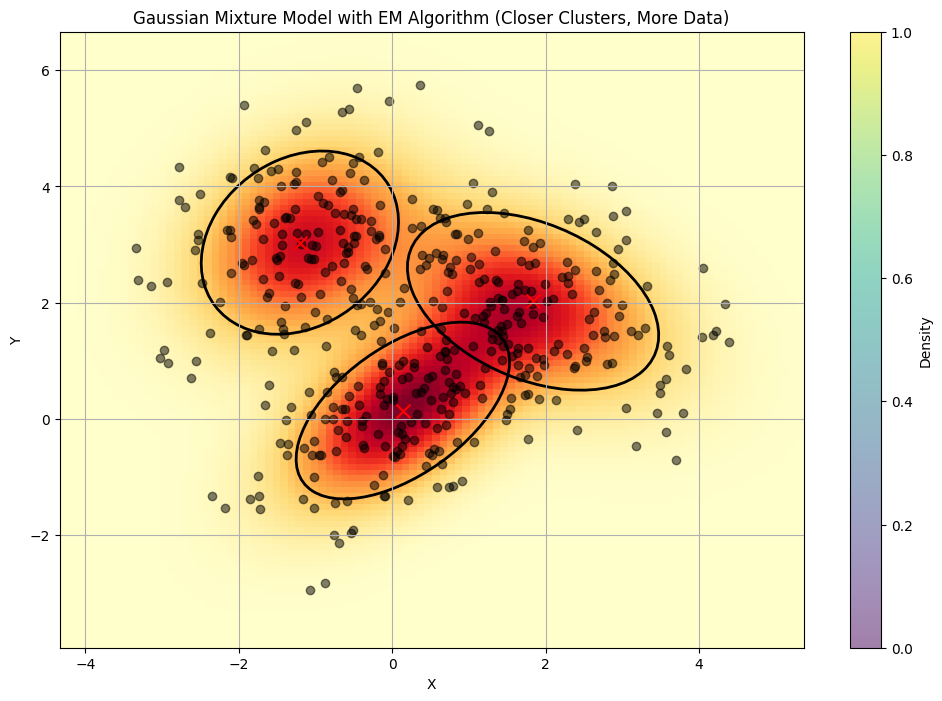

GMM fitting completed.
Number of components: 3
Weights: [0.31627105 0.34659578 0.33713317]
Means: [[-1.2025339   3.03236969]
 [ 0.13979846  0.14308715]
 [ 1.83744141  2.02233218]]
Covariances: [array([[0.82678855, 0.2284286 ],
       [0.2284286 , 1.24280567]]), array([[0.96762377, 0.5813542 ],
       [0.5813542 , 1.15618652]]), array([[ 1.34173341, -0.47785738],
       [-0.47785738,  1.16849571]])]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

# Generate synthetic data with closer clusters and more data points
np.random.seed(42)
n_samples = 450

# Generate three closer clusters with more data points
cluster1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], n_samples // 3)
cluster2 = np.random.multivariate_normal([2, 2], [[1.2, -0.4], [-0.4, 1.2]], n_samples // 3)
cluster3 = np.random.multivariate_normal([-1, 3], [[1, 0.2], [0.2, 1]], n_samples // 3)

# Combine the clusters
data = np.vstack((cluster1, cluster2, cluster3))

class GaussianMixture:
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances_ = [np.eye(n_features) for _ in range(self.n_components)]

    def e_step(self, X):
        n_samples = X.shape[0]
        resp = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            resp[:, k] = self.weights_[k] * multivariate_normal.pdf(X, self.means_[k], self.covariances_[k])

        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def m_step(self, X, resp):
        n_samples, n_features = X.shape

        self.weights_ = resp.sum(axis=0) / n_samples
        self.means_ = resp.T.dot(X) / resp.sum(axis=0)[:, np.newaxis]

        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = np.dot(resp[:, k] * diff.T, diff) / resp[:, k].sum()

    def fit(self, X):
        self.initialize_parameters(X)

        for _ in range(self.max_iter):
            resp = self.e_step(X)
            self.m_step(X, resp)

    def predict(self, X):
        resp = self.e_step(X)
        return resp.argmax(axis=1)

# Function to plot ellipses
def plot_ellipses(ax, weights, means, covariances):
    for n, (weight, mean, covar) in enumerate(zip(weights, means, covariances)):
        if weight > 0.1:
            v, w = np.linalg.eigh(covar)
            angle = np.arctan2(w[0][1], w[0][0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            ell = Ellipse(mean, v[0], v[1], 180 + angle, edgecolor='black', facecolor='none', linewidth=2)
            ax.add_artist(ell)
            ax.scatter(mean[0], mean[1], c='red', s=100, marker='x')

# Fit the Gaussian Mixture Model
n_components = 3
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Create a mesh grid for plotting
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Calculate the density function of the mixture
Z_mix = np.zeros_like(xx)
for i in range(n_components):
    mvn = multivariate_normal(gmm.means_[i], gmm.covariances_[i])
    Z_mix += gmm.weights_[i] * mvn.pdf(np.dstack((xx, yy)))

# Plot the results
plt.figure(figsize=(12, 8))

# Plot heatmap of the density function
plt.imshow(Z_mix, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap='YlOrRd', aspect='auto', origin='lower')

# Plot data points
plt.scatter(data[:, 0], data[:, 1], c='black', alpha=0.5)

# Plot ellipses
plot_ellipses(plt.gca(), gmm.weights_, gmm.means_, gmm.covariances_)

plt.title("Gaussian Mixture Model with EM Algorithm (Closer Clusters, More Data)")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label='Density')
plt.grid(True)
plt.show()

print("GMM fitting completed.")
print("Number of components:", n_components)
print("Weights:", gmm.weights_)
print("Means:", gmm.means_)
print("Covariances:", gmm.covariances_)

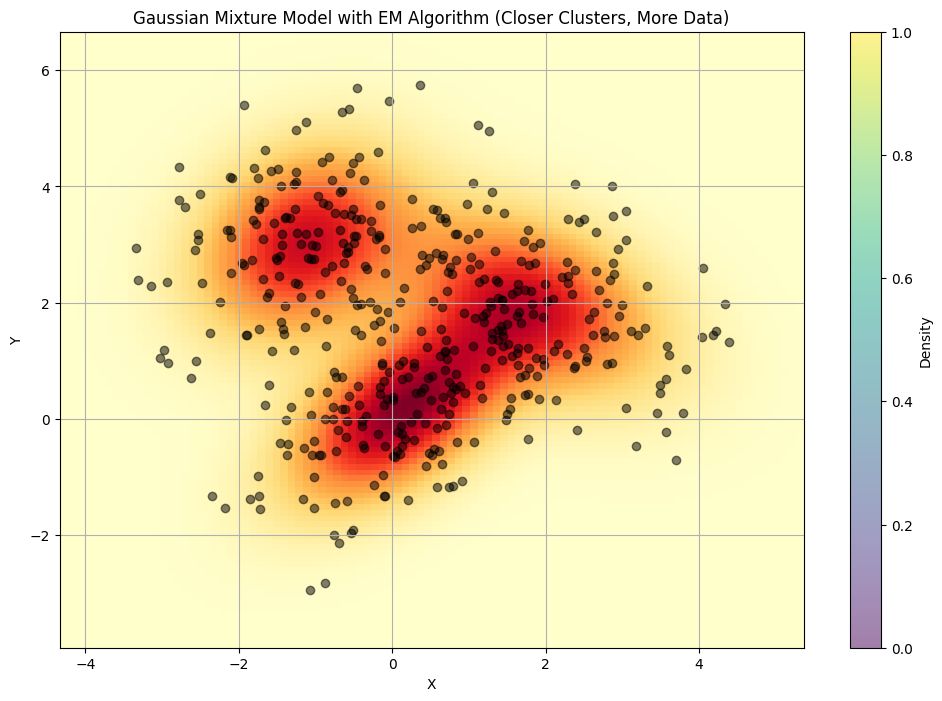

GMM fitting completed.
Number of components: 3
Weights: [0.31627105 0.34659578 0.33713317]
Means: [[-1.2025339   3.03236969]
 [ 0.13979846  0.14308715]
 [ 1.83744141  2.02233218]]
Covariances: [array([[0.82678855, 0.2284286 ],
       [0.2284286 , 1.24280567]]), array([[0.96762377, 0.5813542 ],
       [0.5813542 , 1.15618652]]), array([[ 1.34173341, -0.47785738],
       [-0.47785738,  1.16849571]])]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Generate synthetic data with closer clusters and more data points
np.random.seed(42)
n_samples = 450

# Generate three closer clusters with more data points
cluster1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], n_samples // 3)
cluster2 = np.random.multivariate_normal([2, 2], [[1.2, -0.4], [-0.4, 1.2]], n_samples // 3)
cluster3 = np.random.multivariate_normal([-1, 3], [[1, 0.2], [0.2, 1]], n_samples // 3)

# Combine the clusters
data = np.vstack((cluster1, cluster2, cluster3))

class GaussianMixture:
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances_ = [np.eye(n_features) for _ in range(self.n_components)]

    def e_step(self, X):
        n_samples = X.shape[0]
        resp = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            resp[:, k] = self.weights_[k] * multivariate_normal.pdf(X, self.means_[k], self.covariances_[k])

        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def m_step(self, X, resp):
        n_samples, n_features = X.shape

        self.weights_ = resp.sum(axis=0) / n_samples
        self.means_ = resp.T.dot(X) / resp.sum(axis=0)[:, np.newaxis]

        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = np.dot(resp[:, k] * diff.T, diff) / resp[:, k].sum()

    def fit(self, X):
        self.initialize_parameters(X)

        for _ in range(self.max_iter):
            resp = self.e_step(X)
            self.m_step(X, resp)

    def predict(self, X):
        resp = self.e_step(X)
        return resp.argmax(axis=1)

# Fit the Gaussian Mixture Model
n_components = 3
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Create a mesh grid for plotting
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Calculate the density function of the mixture
Z_mix = np.zeros_like(xx)
for i in range(n_components):
    mvn = multivariate_normal(gmm.means_[i], gmm.covariances_[i])
    Z_mix += gmm.weights_[i] * mvn.pdf(np.dstack((xx, yy)))

# Plot the results
plt.figure(figsize=(12, 8))

# Plot heatmap of the density function
plt.imshow(Z_mix, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap='YlOrRd', aspect='auto', origin='lower')

# Plot data points
plt.scatter(data[:, 0], data[:, 1], c='black', alpha=0.5)

plt.title("Gaussian Mixture Model with EM Algorithm (Closer Clusters, More Data)")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label='Density')
plt.grid(True)
plt.show()

print("GMM fitting completed.")
print("Number of components:", n_components)
print("Weights:", gmm.weights_)
print("Means:", gmm.means_)
print("Covariances:", gmm.covariances_)

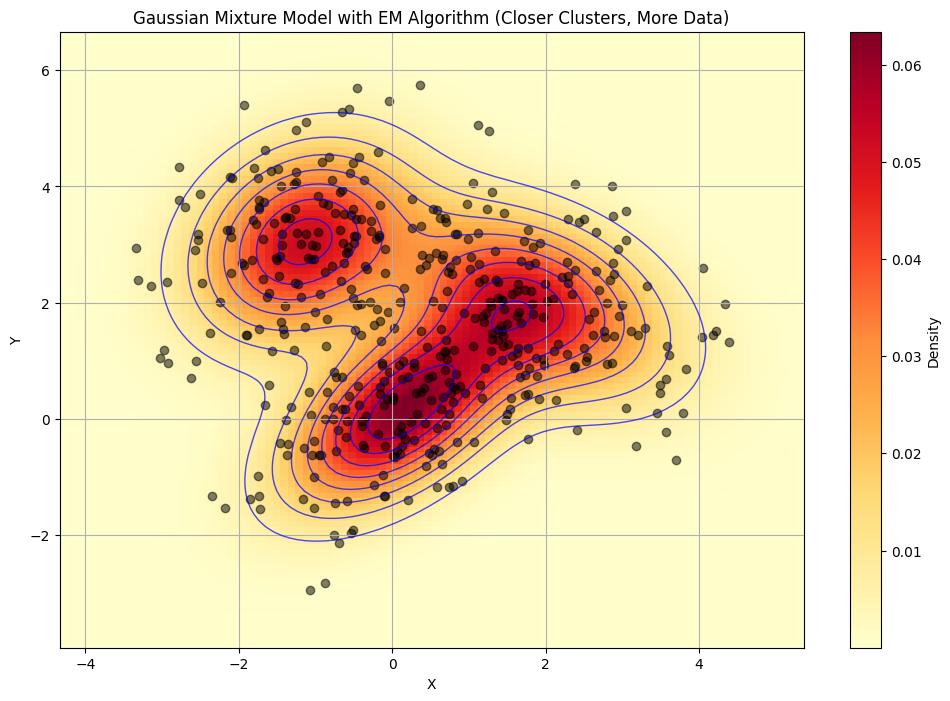

GMM fitting completed.
Number of components: 3
Weights: [0.31627105 0.34659578 0.33713317]
Means: [[-1.2025339   3.03236969]
 [ 0.13979846  0.14308715]
 [ 1.83744141  2.02233218]]
Covariances: [array([[0.82678855, 0.2284286 ],
       [0.2284286 , 1.24280567]]), array([[0.96762377, 0.5813542 ],
       [0.5813542 , 1.15618652]]), array([[ 1.34173341, -0.47785738],
       [-0.47785738,  1.16849571]])]


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Generate synthetic data with closer clusters and more data points
np.random.seed(42)
n_samples = 450

# Generate three closer clusters with more data points
cluster1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], n_samples // 3)
cluster2 = np.random.multivariate_normal([2, 2], [[1.2, -0.4], [-0.4, 1.2]], n_samples // 3)
cluster3 = np.random.multivariate_normal([-1, 3], [[1, 0.2], [0.2, 1]], n_samples // 3)

# Combine the clusters
data = np.vstack((cluster1, cluster2, cluster3))

class GaussianMixture:
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances_ = [np.eye(n_features) for _ in range(self.n_components)]

    def e_step(self, X):
        n_samples = X.shape[0]
        resp = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            resp[:, k] = self.weights_[k] * multivariate_normal.pdf(X, self.means_[k], self.covariances_[k])

        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def m_step(self, X, resp):
        n_samples, n_features = X.shape

        self.weights_ = resp.sum(axis=0) / n_samples
        self.means_ = resp.T.dot(X) / resp.sum(axis=0)[:, np.newaxis]

        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = np.dot(resp[:, k] * diff.T, diff) / resp[:, k].sum()

    def fit(self, X):
        self.initialize_parameters(X)

        for _ in range(self.max_iter):
            resp = self.e_step(X)
            self.m_step(X, resp)

    def predict(self, X):
        resp = self.e_step(X)
        return resp.argmax(axis=1)

# Fit the Gaussian Mixture Model
n_components = 3
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Create a mesh grid for plotting
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Calculate the density function of the mixture
Z_mix = np.zeros_like(xx)
for i in range(n_components):
    mvn = multivariate_normal(gmm.means_[i], gmm.covariances_[i])
    Z_mix += gmm.weights_[i] * mvn.pdf(np.dstack((xx, yy)))

# Plot the results
plt.figure(figsize=(12, 8))

# Plot heatmap of the density function
im = plt.imshow(Z_mix, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap='YlOrRd', aspect='auto', origin='lower')

# Plot contours of the mixture
levels = np.linspace(Z_mix.min(), Z_mix.max(), 10)
contour = plt.contour(xx, yy, Z_mix, levels=levels, colors='blue', alpha=0.7, linewidths=1)

# Plot data points
plt.scatter(data[:, 0], data[:, 1], c='black', alpha=0.5)

plt.title("Gaussian Mixture Model with EM Algorithm (Closer Clusters, More Data)")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(im, label='Density')
plt.grid(True)
plt.show()

print("GMM fitting completed.")
print("Number of components:", n_components)
print("Weights:", gmm.weights_)
print("Means:", gmm.means_)
print("Covariances:", gmm.covariances_)